In [169]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import datetime
from datetime import datetime
from sklearn.metrics import mean_squared_error


%matplotlib inline
plt.style.use('fivethirtyeight')          #Used for replicating graph styles from fivethirtyeight.com

from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential

from binance.client import Client

In [170]:
client = Client("3NMyXJiv5LqOR9zDrmuCyOnEEVBuV0XX7CDpOwzcZHrgocW0VoR2GJKxU8nRcJPO","tWqMqmODIu6hKqLavQErL177IlVRRNIwy3X43n7L33vlqLjcuWVWHw4FV4M5hatK")

candles = client.get_klines(symbol='BTCUSDT',interval = Client.KLINE_INTERVAL_1MINUTE);

In [171]:
len(candles)

500

In [172]:
candles[499]      #time-open-high-low-close-volume-close_time

[1617755340000,
 '58095.78000000',
 '58111.96000000',
 '58090.32000000',
 '58099.48000000',
 '9.42137100',
 1617755399999,
 '547384.18838512',
 370,
 '4.37894400',
 '254423.16363534',
 '0']

In [173]:
#Fetching closing prices from candlesticks data

price = np.array([float(candles[i][4]) for i in range(500)])

In [174]:
#Fetching opening time from candlesticks data
time = np.array([int(candles[i][0]) for i in range(500)])

#Converting time to HH:MM:SS format
t = np.array([datetime.fromtimestamp(time[i]/1000).strftime('%H:%M:%S') for i in range(500)])

In [175]:
price.shape

(500,)

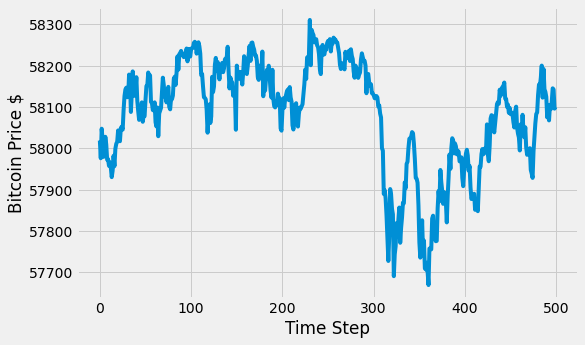

In [176]:
plt.figure(figsize=(8,5))
plt.xlabel("Time Step")
plt.ylabel("Bitcoin Price $")
plt.plot(price)

In [177]:
#Putting this data into a dataframe
timeframe = pd.DataFrame({'Time':t,'Price $BTC':price})
timeframe  #minute by minute price

,Time,Price $BTC
0,21:10:00,58018.60
1,21:11:00,57975.75
2,21:12:00,58047.22
3,21:13:00,58021.48
4,21:14:00,57979.00
...,...,...
495,05:25:00,58112.63
496,05:26:00,58145.00
497,05:27:00,58142.35
498,05:28:00,58095.78


In [178]:
price = price.reshape(500,1)

In [179]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

In [180]:
scaler.fit(price[:374])

StandardScaler()

In [181]:
price = scaler.transform(price)

In [182]:
#Putting the standardized data into dataframe according to input and target(output) columns for model training
df = pd.DataFrame(price.reshape(100,5),columns = ['First','Second','Third','Fourth','Target'])

In [183]:
df.head()

,First,Second,Third,Fourth,Target
0,-0.593382,-0.897548,-0.390227,-0.572939,-0.874478
1,-0.797319,-0.529071,-0.659823,-0.923741,-0.912809
2,-1.028300,-0.966828,-1.058184,-1.222227,-1.112983
3,-0.855525,-1.034262,-0.732511,-0.648395,-0.615174
4,-0.420253,-0.499329,-0.605166,-0.377592,-0.355161


In [184]:
#Split train and test data

x_train = df.iloc[:74,:4]
y_train = df.iloc[:74,-1]

x_test = df.iloc[75:99,:4]
y_test = df.iloc[75:99,-1]

In [185]:
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

In [186]:
x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

In [187]:
x_train.shape, x_test.shape

((74, 4, 1), (24, 4, 1))

In [188]:
#Calibrating and initializing the prediction model

model = Sequential()

model.add(LSTM(20,return_sequences=True,input_shape=(4,1)))
model.add(LSTM(40,return_sequences=False))
model.add(Dense(1,activation='linear'))
model.compile(loss='mse',optimizer='rmsprop')

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 4, 20)             1760      
_________________________________________________________________
lstm_11 (LSTM)               (None, 40)                9760      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 41        
Total params: 11,561
Trainable params: 11,561
Non-trainable params: 0
_________________________________________________________________


In [189]:
model.fit(x_train,y_train,batch_size=5,epochs=100)

Epoch 1/100
15/15 [==============================] - 3s 3ms/step - loss: 1.0423
Epoch 2/100
15/15 [==============================] - 0s 3ms/step - loss: 0.5592
Epoch 3/100
15/15 [==============================] - 0s 3ms/step - loss: 0.3531
Epoch 4/100
15/15 [==============================] - 0s 3ms/step - loss: 0.1351
Epoch 5/100
15/15 [==============================] - 0s 3ms/step - loss: 0.1040
Epoch 6/100
15/15 [==============================] - 0s 3ms/step - loss: 0.1071
Epoch 7/100
15/15 [==============================] - 0s 3ms/step - loss: 0.1005
Epoch 8/100
15/15 [==============================] - 0s 3ms/step - loss: 0.1129
Epoch 9/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0988
Epoch 10/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0975
Epoch 11/100
15/15 [==============================] - 0s 3ms/step - loss: 0.1271
Epoch 12/100
15/15 [==============================] - 0s 3ms/step - loss: 0.1227
Epoch 13/100
15/15 [=================

In [190]:
y_pred = model.predict(x_test)

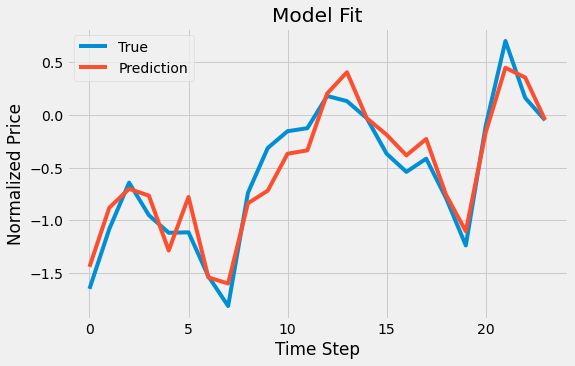

In [191]:
#Plotting the prediction vs actual graph for scaled data
plt.figure(figsize = [8,5])
plt.title('Model Fit')
plt.xlabel('Time Step')
plt.ylabel('Normalized Price')
plt.plot(y_test,label = "True")
plt.plot(y_pred,label="Prediction")
plt.legend()
plt.show()

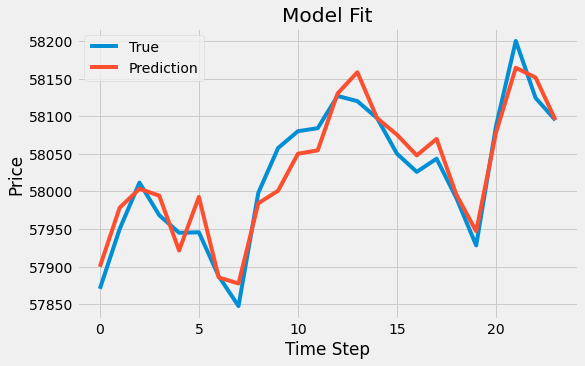

In [192]:
#Plotting the prediction vs actual graph for scaled data
plt.figure(figsize = [8,5])
plt.title('Model Fit')
plt.xlabel('Time Step')
plt.ylabel('Price')
plt.plot(scaler.inverse_transform(y_test),label = "True")
plt.plot(scaler.inverse_transform(y_pred),label="Prediction")
plt.legend()
plt.show()

In [193]:
testScore = np.sqrt(mean_squared_error(scaler.inverse_transform(y_test),scaler.inverse_transform(y_pred)))
print('Test Score : %2f RMSE' % (testScore))

Test Score : 26.604838 RMSE


In [194]:
from sklearn.metrics import r2_score

In [195]:
print('RSquared : ', '{:.2%}'.format(r2_score(y_test,y_pred)))

RSquared :  91.03%


In [196]:
model.save("Bitcoin_model.h5")